# Fit Model Parameters to Data #
### Nitika Yadlapalli ###
Use existing all sky maps published on LAMBDA (https://lambda.gsfc.nasa.gov/) to find model parameters that best fit the data

Currently, MCMC models based on example shown here: https://emcee.readthedocs.io/en/v2.2.1/user/line/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import emcee
import scipy.optimize as op
from scipy import stats
import corner

In [2]:
# relevant constants

c = 3e10
k = 1.381e-16
pc = 3.086e18
d = 8e3*pc # distance from galactic center to sun ~8kpc

Jy = 1e-23 # erg s^-1 cm^-2 Hz^-1

In [3]:
# function describing line of sight through disk and halo models, based on sky coordinates, 
# geometry of disk/halo
# l and b given in degrees (as from hp.pix2ang) - convert to radians
# d = distance of sun from center of galaxy

def LineOfSightDisk(l, b, d, R_disk, h_disk):
    
    l = np.array(l)
    b = np.array(b)
    # first calculate length of line of sight through disk
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)

    l = np.array([np.min([l_, (2*np.pi)-l_]) for l_ in l])
    b = np.abs(b)
    B_disk =  -l - np.arcsin((d/R_disk)*np.sin(l)) + np.pi
    r_disk = np.sqrt(-(2*R_disk*d*np.cos(B_disk)) + (R_disk**2) + (d**2))
    
    b_crit = np.arctan(0.5*h_disk/r_disk)
    b_below = np.nan_to_num((b <= b_crit)*r_disk/(np.cos(b)))
    b_above = np.nan_to_num((b > b_crit)*0.5*h_disk/(np.sin(b)))
    
    D_disk = b_below+b_above
    
#     if b <= np.arctan(0.5*h_disk/r_disk):
#         D_disk = r_disk/(np.cos(b))

        
#     else: 
#         D_disk = 0.5*h_disk/(np.sin(b))
        
    return np.array(D_disk)
        

def LineOfSightHalo(l, b, d, R_halo):  
    
    # next calculate length of line of sight through halo
    
    l = np.deg2rad(np.array(l))
    b = np.deg2rad(np.array(b))
    
    l = np.minimum(l, (2*np.pi)-l)
    
    b = np.abs(b)
    b_ = np.pi - b
    
    d_proj = d*np.abs(np.cos(l))
    B_halo1 = np.pi - l - np.arcsin((d/R_halo)*np.sin(l))
    
#     if l > np.pi/2:
#         b = b_
    R_eff_above = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) + d_proj
    B_halo_above = (np.pi - b_ - np.arcsin((d_proj/R_eff_above)*np.sin(b)))
    D_tot_above = (l >= np.pi/2)*(np.sqrt((R_eff_above**2) + (d_proj**2) - (2*R_eff_above*d_proj*np.cos(B_halo_above))))
        
#     else: 
    R_eff_below = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) - d_proj
    B_halo_below = (np.pi - b - np.arcsin((d_proj/R_eff_below)*np.sin(b)))
    D_tot_below = (l < np.pi/2)*(np.sqrt((R_eff_below**2) + (d_proj**2) - (2*R_eff_below*d_proj*np.cos(B_halo_below))))
    
    
    D_halo = D_tot_above + D_tot_below
    
#     if D_halo < 0:
#         D_halo = 0
    
    return D_halo

## 1.4 GHz Map with Disk and Extragalactic Only Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk (no halo), and use uniform extragalactic sky brightness as calculated in sky-brightness-model notebook

In [4]:
## Set up known parameters ##

NSIDE_sky = 256

NSIDE_dg = 32
NPIX_dg = hp.nside2npix(NSIDE_dg)

m = np.arange(NPIX_dg)
coords = hp.pix2ang(NSIDE_dg, m, lonlat=True)
l = coords[0]
b = coords[1]

nu = 1420e6
T_eg = 0.08866 # K
T_rms = (50/3)*1e-3 # K
T_CMB = 2.725 # K

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


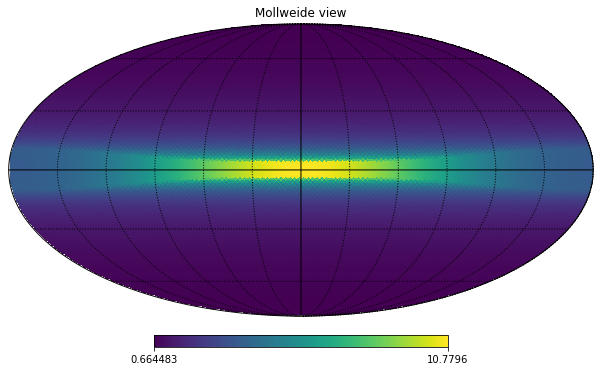

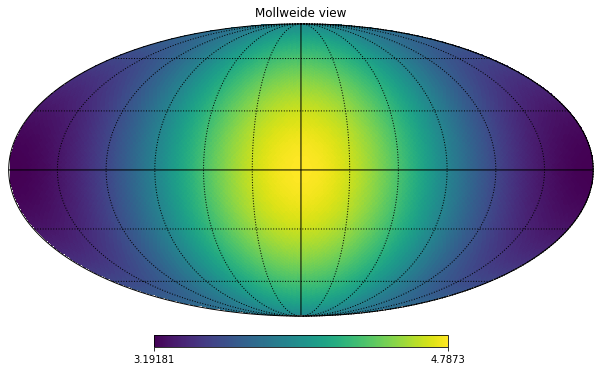

In [5]:
# test  models

test_disk = LineOfSightDisk(l, b, d, 2*d, 0.37*d)*9e-41*(c**2)/(2*k*(nu**2))
hp.mollview(test_disk)
hp.graticule()

test_halo = LineOfSightHalo(l, b, d, 5*d)*2e-41*(c**2)/(2*k*(nu**2))
hp.mollview(test_halo)
hp.graticule()

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1177: RuntimeWarning: invalid value encountered

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


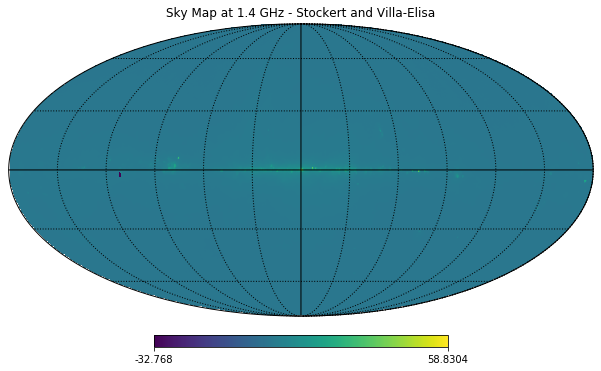

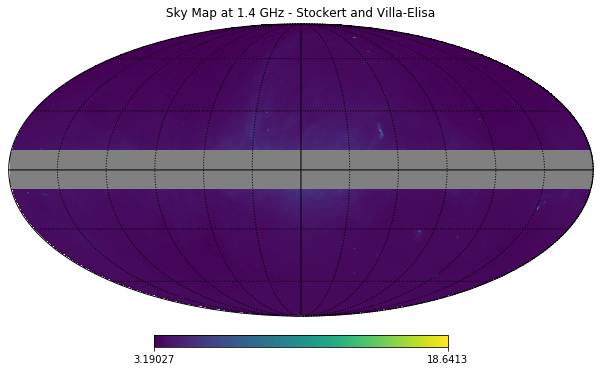

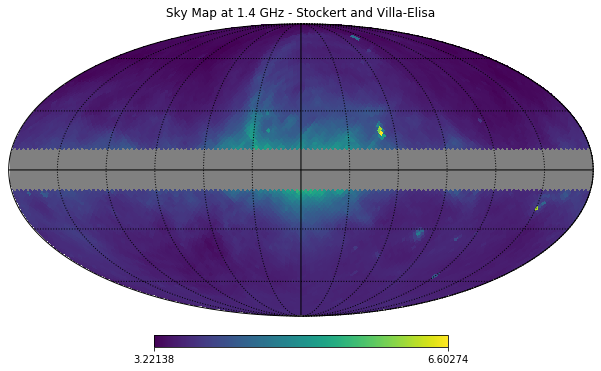

In [6]:
## show 1.4 GHz sky map ##

map_1420 = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_mod = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_dg = hp.pixelfunc.ud_grade(map_1420, 32)

#Mask all pixels between -10 < b < +10 by setting them all to zero
idx = hp.query_strip(NSIDE_sky, np.deg2rad(90-10), np.deg2rad(90+10))
map_1420_mod[idx] = None
#map_1420_dg[idx] = None

idx_dg = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))
map_1420_dg[idx_dg] = None

hp.mollview(map_1420/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_mod/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_dg/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

In [ ]:
# # def log of likelihood function

# def lnlike(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    
#     #idx_exb = latitudes of -10 < b < 10 that we wish to exclude
    
#     R_disk = disk[0]
#     h_disk = disk[1]
#     j_disk = disk[2]
    
#     # residuals = T_res = T_sky - T_eg - T_disk
#     T_notdisk = T_sky/1000 - T_eg - T_CMB
#     residuals = T_notdisk - LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2))
#     residuals[idx_exb] = None
    
#     neg_res_idx = np.argwhere(residuals<=0)
#     neg_res = residuals[neg_res_idx]
    
#     if len(neg_res)==0:
#         return -np.inf
    
#     neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))
#     L = stats.kstest(neg_res2.T, 'norm')[1]

#     lnL = np.log(L)
#     return lnL


# def lnlike2(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    
#     #idx_exb = latitudes of -10 < b < 10 that we wish to exclude
    
#     R_disk = disk[0]
#     h_disk = disk[1]
#     j_disk = disk[2]
    
#     # residuals = T_res = T_sky - T_eg - T_disk
#     T_notdisk = T_sky/1000 - T_eg - T_CMB
#     residuals = T_notdisk - LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2))
#     residuals[idx_exb] = None
    
#     neg_res_idx = np.argwhere(residuals<=0)
#     neg_res = residuals[neg_res_idx]
    
#     if len(neg_res)<3:
#         return -np.inf
    
#     neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))
#     L = stats.shapiro(neg_res2.T[0])[1]

#     lnL = np.log(L)
#     return lnL


In [ ]:
# # set up log priors

# def lnprior(disk):
    
#     R_disk = disk[0]
#     h_disk = disk[1]
#     j_disk = disk[2]

#     if d < R_disk < 1000*d and 0 < h_disk < 5*d and 1e-42 < j_disk < 1e-39:
#         return 0.0
    
#     return -np.inf


In [ ]:
# # full log probability 

# def lnprob(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
#     lp = lnprior(disk)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb)

# def lnprob2(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
#     lp = lnprior(disk)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike2(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb)

In [ ]:
# # Use this cell to test good starting point for walkers

# idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))

# testln = lnlike([2*d, 0.35*d, 2.5e-41], nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb)
# print(testln)
# print(np.exp(testln))

# testln2 = lnlike2([2*d, 0.35*d, 2.5e-41], nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb)
# print(testln2)
# print(np.exp(testln2))

In [ ]:
# # initialize walkers

# ndim = 3
# nwalkers = 200
# disk_init = [2*d, 0.35*d, 2.5e-41]

# init = [disk_init]
# for i in range(nwalkers-1):
#     #start walkers such that all values are positive and mean multiplicative factor is 1
#     vary = np.abs(np.random.randn(3)+1)
#     init.append([disk_init[i]*vary[i] for i in range(3)])

In [ ]:
#set up sampler and run MCMC

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb))

# sampler.run_mcmc(init, 2000)

In [ ]:
# samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
# print(samples.shape)
# samples[:,0] = np.log10(samples[:,0])
# samples[:,1] = np.log10(samples[:,1])
# samples[:,2] = np.log10(samples[:,2])

In [ ]:
# fig = corner.corner(samples, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$"], show_titles=True)
# plt.savefig('notes/corner_disk_kstest.jpg')

In [ ]:
# # look at individual chains

# print(50*d)
# print(10**np.max(samples[:,0]))

# x = sampler.chain
# print(x.shape)

# #plt.plot(x[:,:,2][25], 'k-')
# #plt.imshow

In [ ]:
# sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb))

# sampler2.run_mcmc(init, 1000)

In [ ]:
# samples2 = sampler2.chain[:, 50:, :].reshape((-1, ndim))
# print(samples2.shape)
# samples2[:,0] = np.log10(samples2[:,0])
# samples2[:,1] = np.log10(samples2[:,1])
# samples2[:,2] = np.log10(samples2[:,2])

# R_disk2, h_disk2, j_disk2 = np.percentile(samples2[:,0], 50), np.percentile(samples2[:,1], 50), np.percentile(samples2[:,2], 50)

In [ ]:
# fig2 = corner.corner(samples2, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$"], show_titles=True, quantiles=[0.16, 0.5, 0.84])
# plt.savefig('notes/corner_disk_shapiro.jpg')

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


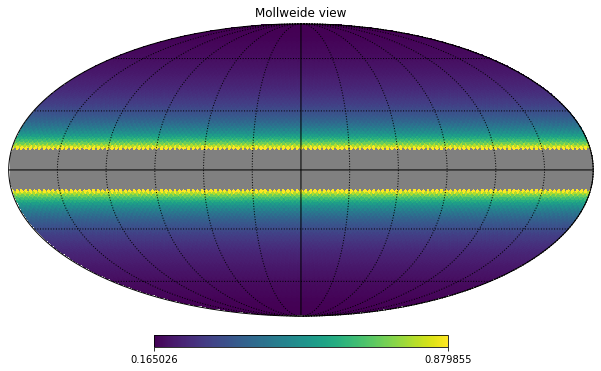

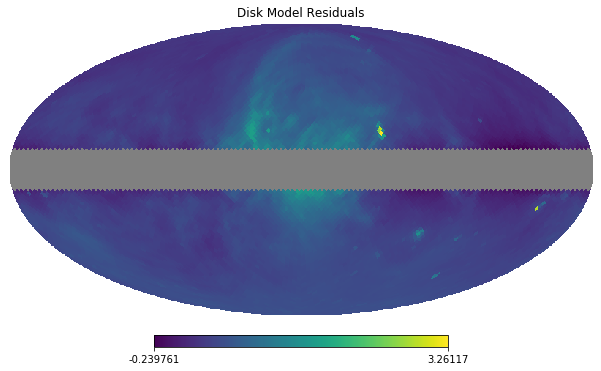

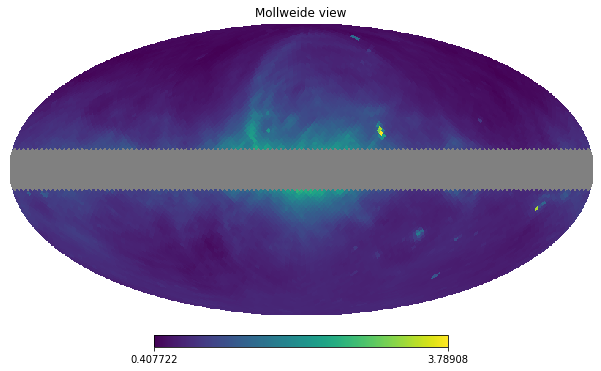

In [96]:
disk_model = LineOfSightDisk(l, b, d, 10**24.78, 10**21.92)*(10**(-40.61))*(c**2)/(2*k*(nu**2))
disk_model[idx_dg]= None
hp.mollview(disk_model)
hp.graticule()

res = map_1420_dg/1000 - disk_model - T_CMB - T_eg
hp.mollview(res, title="Disk Model Residuals")
plt.savefig("notes/res_diskmcmc.jpg")

map_1420_dg[idx_dg]=None
sky = map_1420_dg/1000 - T_CMB - T_eg
hp.mollview(sky)

In [ ]:
# Construct a T_b vs csc(b) graph

b_range = np.linspace(10,90,15)

cscb = []

Tb_disk = []
Tb_sky = []
Tb_res = []

for i in range(len(b_range)-1):
    
    b1 = 90 - b_range[i]
    b2 = 90 - b_range[i+1]
    
    bmid = 0.5*(b_range[i] + b_range[1+i])
    
    cscb.append(1/(np.sin(np.deg2rad(bmid)))) 
    
    idx = hp.query_strip(NSIDE_dg, np.deg2rad(b2), np.deg2rad(b1))
    Tb_disk.append(np.mean(disk_model[idx]))
    Tb_sky.append(np.mean(sky[idx]))
    Tb_res.append(np.mean(res[idx]))
    
plt.figure(0)
plt.rcParams.update({'font.size': 12})
plt.title('Brightness Profile of 1.4 GHz Sky')
plt.ylabel('T (K)')
plt.xlabel('csc(b)')
plt.plot(cscb, Tb_sky, 'r.', label='All-Sky Map')
plt.plot(cscb, Tb_disk, 'b.', label='Disk Model')
plt.legend()
plt.savefig('notes/1420_cscb_compare.jpg')

In [ ]:
neg_res_idx = np.argwhere(res<=0)
neg_res = res[neg_res_idx]
neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))

plt.figure()
# plt.hist(neg_res2.T[0], 10)

plt.figure()
plt.hist(res)

plt.figure()
plt.hist(neg_res2)


## 1.4 GHz Map with Disk+Halo and Extragalactic Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk+halo, and use uniform extragalactic sky brightness as calculated in sky-brightness-model notebook

In [7]:
# def log of likelihood function

def lnlike(param, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    
    #idx_exb = latitudes of -10 < b < 10 that we wish to exclude
    
    R_disk = param[0]
    h_disk = param[1]
    j_disk = param[2]
    R_halo = param[3]
    j_halo = param[4]
    
    # residuals = T_res = T_sky - T_eg - T_disk - T_halo
    T_notdisk = T_sky/1000 - T_eg - T_CMB
    residuals = T_notdisk - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
    residuals[idx_exb] = None
    
    neg_res_idx = np.argwhere(residuals<=0)
    neg_res = residuals[neg_res_idx]
    
    if len(neg_res)==0:
        return -np.inf
    
    neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))
    L = stats.kstest(neg_res2.T, 'norm')[1]

    lnL = np.log(L)
    return lnL

# set up log priors

def lnprior(param):
    
    R_disk = param[0]
    h_disk = param[1]
    j_disk = param[2]
    R_halo = param[3]
    j_halo = param[4]
    
    if d < R_disk < 100*d and 0 < h_disk < 5*d and 1e-42 < j_disk < 1e-39 and R_halo > 0 and 1e-43 < j_halo < 1e-38 :
        return 0.0
    
    return -np.inf


# full log probability 

def lnprob(param, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(param, nu, l, b, T_sky, T_eg, T_rms, idx_exb)

In [8]:
# Use this cell to test good starting point for walkers
idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))

testln = lnlike([2*d, 0.17*d, 2e-41, 4*d, 2.2e-42], nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb)
print(testln)
print(np.exp(testln))

-0.037691163331336396
0.963010307865293


/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [31]:
# initialize walkers

ndim = 5
nwalkers = 200
param_init = [2*d, 0.17*d, 2e-41, 4*d, 2.2e-42]

init = [param_init]
for i in range(nwalkers-1):
    #start walkers such that all values are positive and mean multiplicative factor is 1
    vary = np.abs(np.random.randn(ndim)+1)
    init.append([param_init[i]*vary[i] for i in range(ndim)])
    
init = np.array(init)

In [32]:
#set up sampler and run MCMC

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb))

SAMPLER = sampler.run_mcmc(init, 1000)

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in arcsin
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in arcsin
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


In [42]:
samples = np.array(sampler.chain)

In [62]:
samples_reshape = samples.reshape((-1, ndim))
samples_corner = np.log10(samples_reshape)

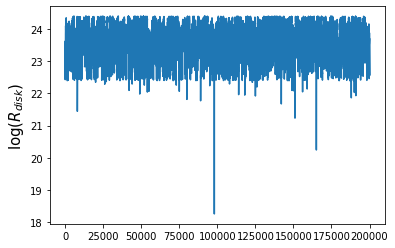

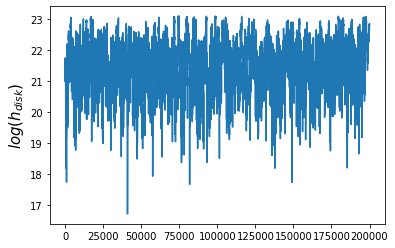

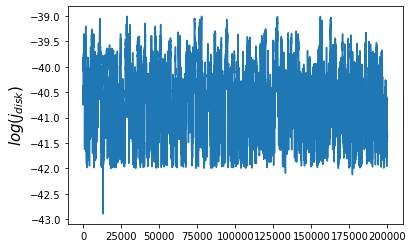

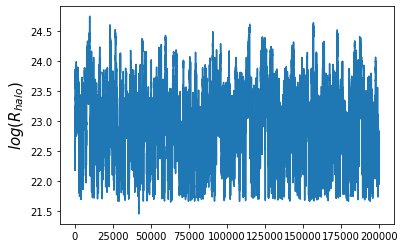

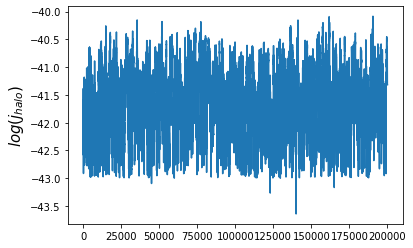

In [63]:
labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$"]
for i in range(ndim):
    plt.figure(i)
    plt.plot(samples_corner[:,i])
    plt.ylabel(labels[i], fontsize='15')

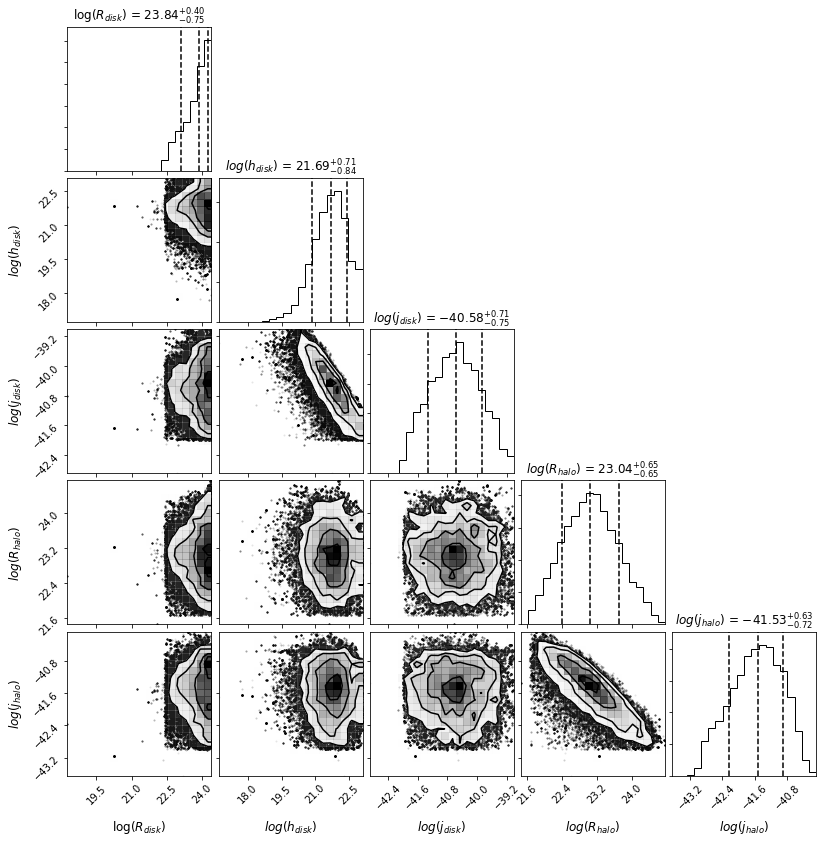

In [64]:
fig = corner.corner(samples_corner, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig("notes/corner_disk+halo_kstest.jpg")

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


Text(0.5, 1.0, 'Negative Residuals Histogram')

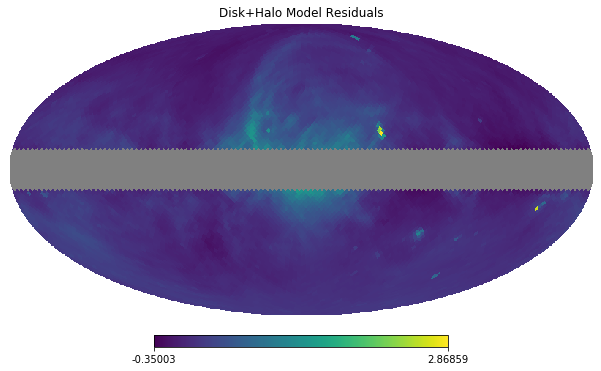

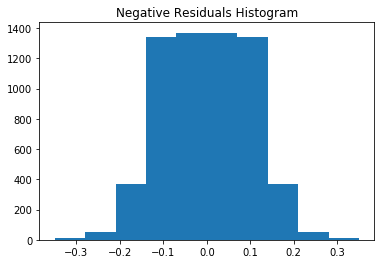

In [97]:
# plot residuals

R_disk = 10**np.percentile(samples_corner[:,0], 50)
h_disk = 10**np.percentile(samples_corner[:,1], 50)
j_disk = 10**np.percentile(samples_corner[:,2], 50)
R_halo = 10**np.percentile(samples_corner[:,3], 50)
j_halo = 10**np.percentile(samples_corner[:,4], 50)


T_notdisk = map_1420_dg/1000 - T_eg - T_CMB
residuals = T_notdisk - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
residuals[idx_exb] = None

neg_res_idx = np.argwhere(residuals<=0)
neg_res = residuals[neg_res_idx]
neg_res2 = np.concatenate((neg_res, -1*neg_res))

hp.mollview(residuals, title="Disk+Halo Model Residuals")
plt.savefig("notes/res_disk+halomcmc.jpg")

plt.figure()
plt.hist(neg_res2, 10)
plt.title('Negative Residuals Histogram')


In [95]:
# Mean acceptance fraction

avg_acc = np.mean(sampler.acceptance_fraction)

print(avg_acc)

0.176815
